# MNIST認識のディープラーニングモデルの評価

## ライブラリのインポート
 - 必要なライブラリをインポートします。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from config.config import load_config 
from models.model import NeuralNetworkModel
import utils.model_utils as model_utils
from utils.plot_metrics import plot_metrics_from_json
import os 
import glob
import json

## 評価するモデルのバージョンを選択

test_model_version 変数は、モデルバージョンを指定するための入力として使用されます。この変数には3つの異なる形式が有効です。

- 'experimentresult': 本プロジェクト作成者による実験結果です。experimentresultの実験について、本Notebookにグラフと考察が記載されています。
- 'latest': 最新のモデルバージョンを使用するための指定です。
- 数値文字列（例: '1'、'2'、'10' など）: 指定したモデルバージョン番号を使用するための指定です。

In [7]:
# 評価するモデルのバージョンを指定
evaluation_model_version = 'experimentresult'

# configを読み取り
config = load_config("config/config.json")

# 最新のモデルバージョンを取得
if evaluation_model_version == 'experimentresult':
    model_version = evaluation_model_version
elif evaluation_model_version == 'latest':
    model_version = model_utils.get_latest_model_version(config["model_save_dir"])
elif isinstance(evaluation_model_version, str) and evaluation_model_version.isdigit():
    model_version = evaluation_model_version
else:
    raise ValueError("Invalid input for test_model_version. Please use 'experimentresult', 'latest', or a valid integer string.")


## デバイスの設定とモデルの読み込み
 - 訓練済みモデルをロードし、デバイスを設定します。

In [8]:
# モデルのパスを取得
model_folder = os.path.join(config["model_save_dir"], str(model_version))
metrics_folder_path = os.path.join(model_folder, 'metrics')
model_paths = glob.glob(os.path.join(model_folder, f"model_version_{model_version}_*.pt"))
latest_model_path = max(model_paths, key=os.path.getctime) 

# モデルの初期化
model = NeuralNetworkModel()

# GPUが利用可能かどうかを確認し、デバイスを設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 訓練済みのウェイトをロード
model_utils.load_model(model, latest_model_path)
model.eval()

NeuralNetworkModel(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## テストデータの読み込みと前処理: 
 - テストデータを読み込み、前処理を行います。

In [9]:
# テストデータをロード
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = torchvision.datasets.MNIST(root='./data/mnist_data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


## 訓練損失、テスト損失、およびテスト精度を表示: 
 - エポック毎の訓練損失、テスト損失、およびテスト精度の結果をメトリクスファイル読み込んでからテーブルで表示します。

In [10]:
# 訓練損失ファイルのパスを作成
train_loss_file_path = os.path.join(metrics_folder_path, 'training_losses.json')

# 検証損失ファイルのパスを作成
validation_loss_file_path = os.path.join(metrics_folder_path, 'validation_losses.json')

# テスト損失ファイルのパスを作成
test_loss_file_path = os.path.join(metrics_folder_path, 'test_losses.json')

# テスト精度ファイルのパスを作成
test_accuracy_file_path = os.path.join(metrics_folder_path, 'test_accuracy.json')

# 訓練損失を読み込む
if os.path.exists(train_loss_file_path):
    with open(train_loss_file_path, 'r') as f:
        training_losses_data = json.load(f)
        training_losses = [list(value_dict.values())[0] for value_dict in training_losses_data]
else:
    training_losses = []

# 検証損失を読み込む
if os.path.exists(validation_loss_file_path):
    with open(validation_loss_file_path, 'r') as f:
        validation_losses_data = json.load(f)
        validation_losses = [list(value_dict.values())[0] for value_dict in validation_losses_data]
else:
    validation_losses = []

# テスト損失を読み込む
if os.path.exists(test_loss_file_path):
    with open(test_loss_file_path, 'r') as f:
        test_losses_data = json.load(f)
        test_losses = [list(value_dict.values())[0] for value_dict in test_losses_data]
else:
    test_losses = []

# テスト精度を読み込む
if os.path.exists(test_accuracy_file_path):
    with open(test_accuracy_file_path, 'r') as f:
        test_accuracy_data = json.load(f)
        test_accuracy = [list(value_dict.values())[0] for value_dict in test_accuracy_data]
else:
    test_accuracy = []

# モデルファイルのパスを取得し、最終更新日時でソート
model_paths = sorted(model_paths, key=lambda path: int(path.split('_')[-3][5:]))

# モデルの数を取得
num_models = min(len(training_losses), len(validation_losses), len(test_losses), len(test_accuracy))

# モデルバージョンの表示
print(f"Model Version: {model_version}")
print()

# テーブルのヘッダー
header = "{:<5} | {:<15} | {:<15} | {:<15} | {:<15} | {:<40}"
separator = "-" * 140
print(header.format("Epoch", "Training Loss", "Validation Loss", "Test Loss", "Test Accuracy", "Model"))
print(separator)

# 各モデルのメトリクスを表示
for i in range(num_models):
    model_file_name = model_paths[i].split('/')[-1]
    model_name = model_file_name
    print(header.format(i + 1, f"{training_losses[i]:.4f}", f"{validation_losses[i]:.4f}", f"{test_losses[i]:.4f}", f"{test_accuracy[i]:.4f}", model_name))


Model Version: experimentresult

Epoch | Training Loss   | Validation Loss | Test Loss       | Test Accuracy   | Model                                   
--------------------------------------------------------------------------------------------------------------------------------------------
1     | 0.4247          | 0.2618          | 0.2395          | 0.9291          | model_version_experimentresult_epoch1_2023-08-26_10-13-18.pt
2     | 0.2145          | 0.1964          | 0.1797          | 0.9435          | model_version_experimentresult_epoch2_2023-08-26_10-13-26.pt
3     | 0.1584          | 0.1517          | 0.1439          | 0.9537          | model_version_experimentresult_epoch3_2023-08-26_10-13-34.pt
4     | 0.1286          | 0.1436          | 0.1330          | 0.9583          | model_version_experimentresult_epoch4_2023-08-26_10-13-42.pt
5     | 0.1080          | 0.1283          | 0.1243          | 0.9620          | model_version_experimentresult_epoch5_2023-08-26_10-13-50.pt


## 損失と精度のグラフの表示: 
 - 訓練損失とテスト損失、テスト精度のグラフを表示します。

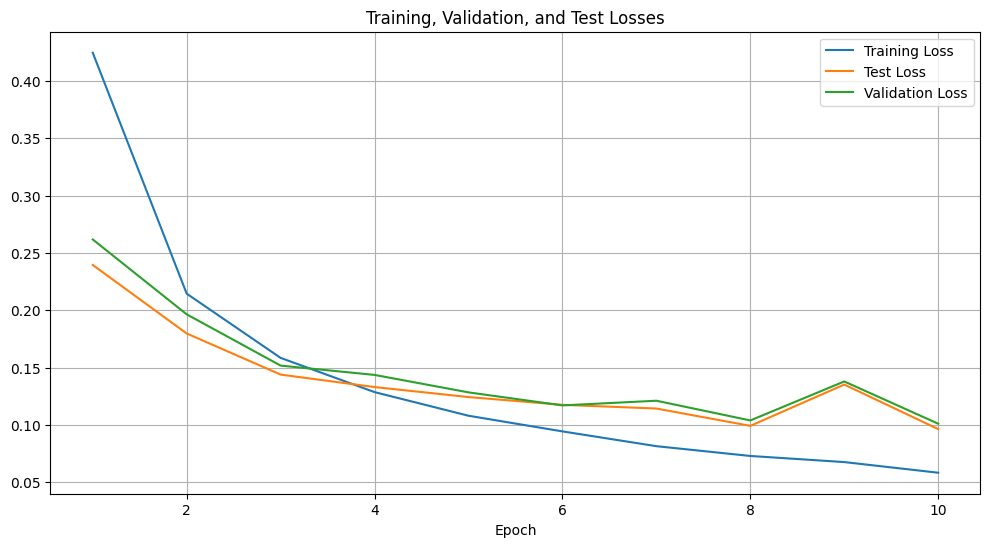

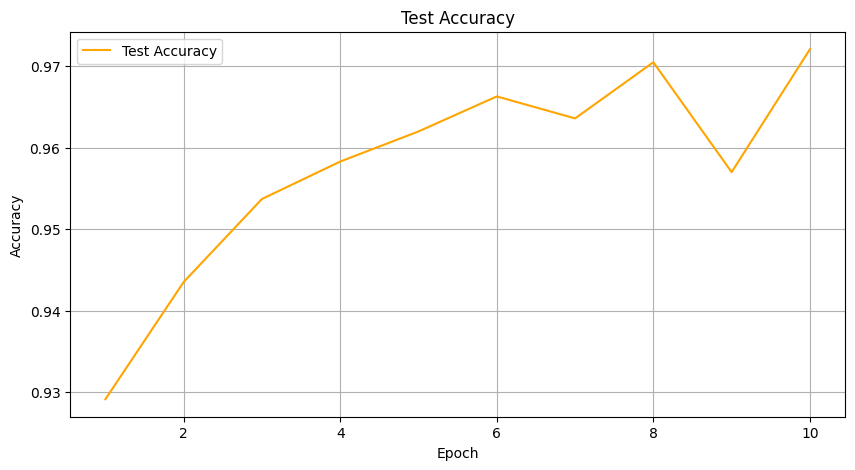

In [11]:
plot_metrics_from_json(metrics_folder_path)

## モデル予測とグラウンドトゥルースの比較
 - モデルの予測とグラウンドトゥルースを比較して表示します。

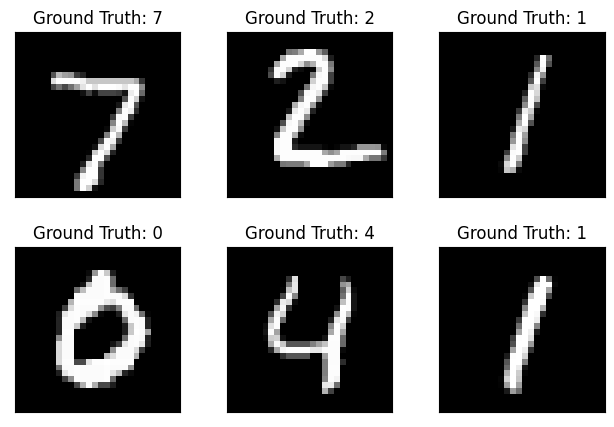

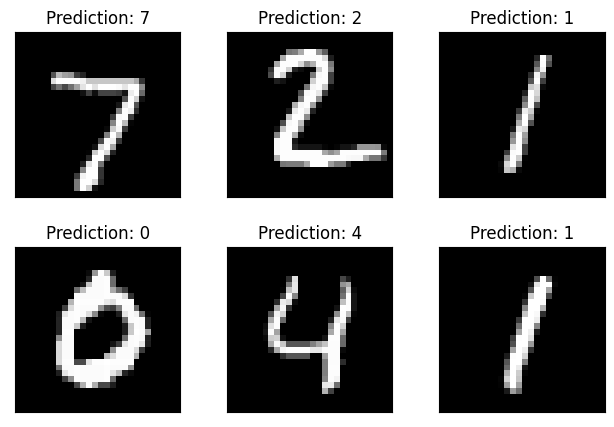

In [12]:
# テストデータセットの列挙を作成
examples = enumerate(test_loader)

# 最初のバッチのデータを取得
batch_idx, (example_data, example_targets) = next(examples)

# 画像表示用の図を作成
fig = plt.figure()

# 最初の6つの画像を表示
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# モデルの推論を行うために、テストデータをデバイスに移動して計算グラフの作成を停止
with torch.no_grad():
    output = model(example_data.to(device))

# 予測結果を表示するための図を作成
fig = plt.figure()

# 最初の6つの画像に対する予測を表示
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])

## テスト結果の考察

モデルのテスト精度が97.21%という高い値を示すことから、訓練されたモデルがMNISTデータセットに対して優れた識別力を持っていることが確認されました。この精度の達成は、モデルが異なる手書き数字の特徴をキャプチャし、一貫して正確な予測を行う能力を持っていることを示しています。

また、モデルの性能評価において、検証損失（Validation Loss）の考慮も重要です。検証損失はモデルが未知のデータにどれだけ適合しているかを示す指標であり、訓練データに過剰適合している場合や未知のデータに対して一般化できていない場合に高くなる可能性があります。モデルの適切な性能評価には、テスト精度とともに検証損失の評価も欠かせません。

これに加えて、高いテスト精度はモデルの汎化能力が高いことも意味します。モデルは学習データに過剰に適合せず、未知のデータに対しても頑健な予測が行えることが示唆されます。したがって、このモデルは新しい手書き数字データにも適用できる可能性があります。

テスト精度は0.9291から0.9721までの範囲で変動しており、モデルの性能が一貫して高いことを示しています。これにより、モデルが学習データおよびテストデータの両方でうまく機能していることが確認されます。

テスト損失は0.2395から0.0963までの範囲で変動しており、モデルがデータを正確に予測していることを示しており、訓練時に最適化された結果を反映しています。また、訓練損失も0.4247から0.0582まで変動していますが、減少傾向が見られ、モデルが訓練データに適合していることを示しています。

- 損失の観察：

訓練損失とテスト損失が双方とも減少していることから、モデルが訓練データとテストデータの両方に適切に適合していることが分かります。これは、モデルが過剰適合を避けつつ、未知のデータに対しても良好な性能を維持する能力を持っていることを示唆しています。訓練損失とテスト損失が収束していることから、モデルが適切な学習を行っていることがわかります。

- グラフの考察：
また、訓練損失とテスト損失は同じグラフ上（Training, Validation and Test Losses）にプロットされており、エポックが進むにつれて両者とも減少していることが確認できます。これは、モデルが学習を通じてデータに対する理解を向上させていることを示しています。一方で、テスト精度は別(Test Accuracy)のグラフでプロットされており、エポックごとに上昇していることがわかります。これはモデルの性能向上を視覚的に表しています。

これらの結果は、ディープラーニングモデルのMNISTデータセットにおける優れた性能を示しており、手書き数字認識に関連する多岐にわたるアプリケーションにおいて、高度な自動化および精度が実

現可能であることを示しています。